# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape

(45993, 3)

In [4]:
df_content.shape

(1056, 5)

In [5]:
df['email'].nunique()

5148

In [6]:
df['email'].value_counts()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
f5035acf16af3e79700393838fa1023ad38da668      1
81335c2e5917100a5cbdcc2bc0285fed6d685f6d      1
98d4864a24bc8f9915c8c8b5ebd3aa1eaa71cbaf      1
c87e297a1a99ae042be2015ff9056cf13195eefd      1
1f18e8aaccd6c8720180c3fe264c8aef5b00697f      1
Name: count, Length: 5148, dtype: int64

In [7]:
# Descriptive statistics of user's interactions with articles.
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: count, dtype: float64

In [8]:
# Article count by user
article_count = df.groupby('email')['article_id'].count().sort_values(ascending=False)
article_count.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

In [9]:
article_count.median()

3.0

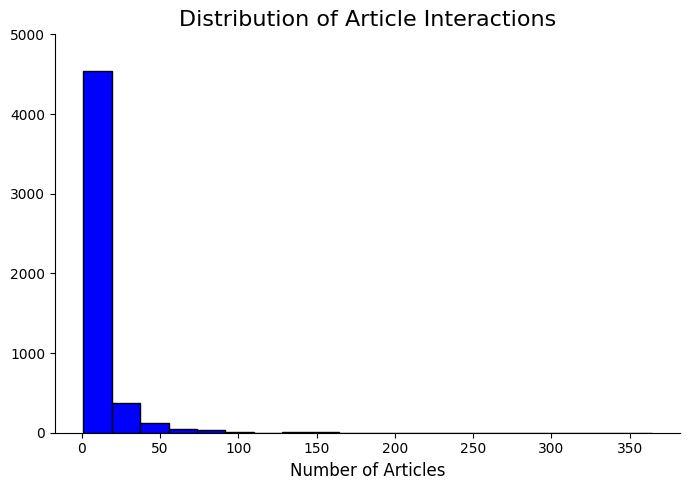

In [10]:
# Plotting histogram of number of articles users interact with

fig, ax = plt.subplots(figsize=(7,5))

ax.hist(article_count, bins=20, color='blue', edgecolor='black')

# Title and labels with styling
ax.set_title('Distribution of Article Interactions', fontsize=16)
ax.set_xlabel('Number of Articles', fontsize=12)

ax.set_ylim(0, 5000)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing tick marks
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjusting the layout for better spacing
plt.tight_layout()

plt.show();


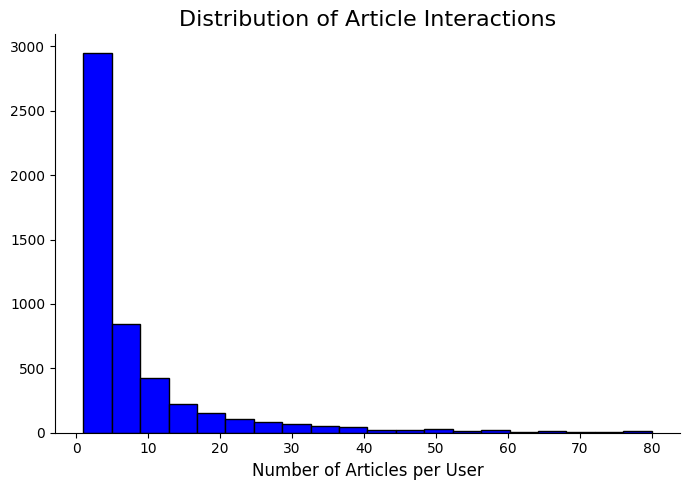

In [11]:
# The above plot is heavily skewed right. This new graph excludes some of the outliers.

fig, ax = plt.subplots(figsize=(7,5))

# Calculate the 99th percentile (top 1%) and filter data
quantile_99 = article_count.quantile(0.99)
filtered_data = article_count[article_count <= quantile_99]

# Histogram of filtered data
ax.hist(filtered_data, bins=20, color='blue', edgecolor='black')

# Title and labels with styling
ax.set_title('Distribution of Article Interactions', fontsize=16)
ax.set_xlabel('Number of Articles per User', fontsize=12)



# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing tick marks
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjusting the layout for better spacing
plt.tight_layout()

plt.show();


In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [13]:
# Find and explore duplicate articles

df_content['article_id'].duplicated().sum()


5

In [14]:
df_content.shape

(1056, 5)

In [15]:
# Remove any rows that have the same article_id
df_content.drop_duplicates(subset=['article_id'], inplace=True)


In [16]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
# The number of unique articles that have an interaction with a user.  
df['article_id'].nunique()


714

In [18]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content['article_id'].nunique()

1051

In [19]:
# The number of unique users in the dataset. (excluding null values)

df['email'].nunique()

5148

In [20]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

In [21]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
# Groups df by 'article_id' and counts the number of occurrences of each 'article_id' (using the 'email' column as a reference), 
# and then sorts the results in descending order by the count of 'email'.

df[['article_id', 'email']].groupby('article_id').count().sort_values('email', ascending=False)


,email
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627
...,...
1113.0,1
1119.0,1
984.0,1


In [23]:
# The most viewed article in the dataset as a string
most_viewed_article_id = '1429.0' 
# The number of views of most viewed article
max_views = 937 

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count number of interactions by title and sort descending
    article_count = df.groupby('title')['user_id'].count().sort_values(ascending=False)
    
    # Select the top 'n' article titles
    top_articles = article_count.index[:n].tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top article IDs to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs
    
    '''
    # Count number of interactions by article_id and sort descending
    id_count = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)
    
    # Select the top 'n' article IDs
    top_article_ids = id_count.index[:n].tolist()
    
    return top_article_ids


In [27]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
# This code creates a pivot table that shows the relationship between 'user_id' and 'article_id'.
# The values in the table represent how many times each user interacted with each article.

pd.crosstab(df['user_id'], df['article_id'])

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create a crosstab of user_id and article_id, counting interactions
    user_item = pd.crosstab(df['user_id'], df['article_id'])
    
    # Convert the values to 1 and 0 (1 for interaction, 0 otherwise)
    user_item = (user_item > 0).astype(int)
    
    return user_item

user_item = create_user_item_matrix(df)


In [31]:
user_item.shape

(5149, 714)

In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user IDs from most to least similar.
    '''
    # Get the interaction vector for the provided user
    user_vector = user_item.loc[user_id]

    # Compute the dot product of this user's vector with all other users' vectors
    similarities = user_item.dot(user_vector)

    # Convert similarities to a DataFrame for easier manipulation
    similarity_df = pd.DataFrame({'user_id': user_item.index, 'similarity': similarities})
    
    # Sort by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    
    # Remove the provided user's id
    similar_users = similarity_df[similarity_df['user_id'] != user_id]['user_id'].tolist()
    
    return similar_users # return a list of the users in order from most to least similar


In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    # Create a list of article titles corresponding to the provided list of article_ids
    # For each article_id in the list of article_ids, do the following:
    # Convert the article_id to float and filter the dataframe to get rows with a matching article_id
    # From the filtered rows, extract the 'title' column and get the first value in the array
    article_names = [df[df['article_id'] == float(i)]['title'].values[0] for i in article_ids]


    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the article_ids seen by the user
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.astype(str).tolist()
    
    # Get article names from df
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names



def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    # Get similar users
    similar_users = find_similar_users(user_id)
    
    # Initialize a list for recommendations
    recs = []
    
    # Iterate over similar users
    for sim_user in similar_users:
        # Get articles seen by similar user
        sim_user_articles, _ = get_user_articles(sim_user)
        
        # Filter out articles that the current user has already seen
        unseen_articles = [article for article in sim_user_articles if article not in get_user_articles(user_id)[0]]
        
        # Add unseen articles to recommendations
        recs.extend(unseen_articles)
        
        # If we have enough recommendations, stop
        if len(recs) >= m:
            break
    
    # Ensure we return only 'm' recommendations
    return recs[:m] # return your recommendations for this user_id


In [36]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [37]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [38]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) the user_id for which we want to find similar users
    df - (pandas dataframe) the dataframe containing interactions
    user_item - (pandas dataframe) matrix of users by articles (1's for interactions, 0 otherwise)

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe containing:
                   neighbor_id - is the neighbor user_id
                   similarity - similarity score between the given user_id and other users
                   num_interactions - number of articles the user has interacted with
    
    Other Details:
    The resulting dataframe is sorted by similarity and then by number of interactions, 
    with higher values of each coming first.
    '''
    
    # Calculate similarity between the given user and others
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Convert similarity to a dataframe, drop the target user, and reset the index
    df_similarity = similarity.drop(user_id).to_frame('similarity').reset_index()
    
    # Get the number of interactions for each user from the df
    num_interactions_df = df['user_id'].value_counts().to_frame('num_interactions')
    
    # Merge similarity with num_interactions
    neighbors_df = df_similarity.merge(num_interactions_df, left_on='user_id', right_index=True)
    
    # Rename the user_id column to neighbor_id
    neighbors_df.rename(columns={'user_id': 'neighbor_id'}, inplace=True)
    
    # Sort the neighbors by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    # Reset the index to get rid of the leftover indexing, and drop the old index
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    
    # Calculate the number of interactions for each article
    article_interactions = df.groupby('article_id').count()['user_id']
    
    # Ensure the article IDs in article_interactions are of a consistent type
    article_interactions.index = article_interactions.index.astype(str)

    # Get sorted neighbors based on similarity
    neighbors_df = get_top_sorted_users(user_id)

    # Get the list of articles the target user has already interacted with
    the_user_articles, _ = get_user_articles(user_id)
    seen_articles = set(the_user_articles)

    recs = set()  # Using a set to ensure no duplicate recommendations
    article_scores = pd.Series(dtype=float)

    # Loop through the closest neighbors and find articles not yet seen by the user
    for neighbor_id in neighbors_df['neighbor_id']:
        neighbor_articles, _ = get_user_articles(neighbor_id)

        # Add only new articles that the user hasn't seen
        new_articles = list(set(neighbor_articles) - seen_articles)
        
        # Convert new_articles to strings to match article_interactions index
        new_articles = [str(article) for article in new_articles]

        # Update article scores based on the number of interactions
        if new_articles:
            new_article_scores = article_interactions.loc[new_articles].fillna(0)
            article_scores = article_scores.add(new_article_scores, fill_value=0)

        if len(article_scores) >= m:
            break

    # Sort articles based on interaction counts and select the top m recommendations
    recs = article_scores.sort_values(ascending=False).head(m).index.tolist()
    
    # Get the names of the recommended articles
    rec_names = get_article_names(recs)

    return recs, rec_names





In [39]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [40]:
get_top_sorted_users(1).head(10)

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158
5,131,14,145
6,3870,14,144
7,46,13,63
8,4201,13,61
9,49,12,147


In [41]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,98,29,170
6,3764,29,169
7,49,29,147
8,3697,29,145
9,242,25,148


In [42]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

### Recommendations for New Users

For a **new user** with no prior interaction data, the most practical approach is to recommend **popular articles** using the `get_top_article_ids()` function. While this gives us a broad starting point, it may not be fully aligned with their preferences. To refine these initial recommendations, we can introduce a **short onboarding questionnaire** to gather insights into their interests. This allows us to mix **content-based filtering** with popular articles, offering a blend of general and personalized suggestions.

As users interact with the platform, we can gradually transition to **collaborative filtering**, utilizing data from similar users to deliver more tailored recommendations. This combination of strategies builds a **dynamic, user-friendly recommendation system** that evolves with the user's engagement.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [44]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)  # Your recommendations here
new_user_recs = list(map(str, new_user_recs))  # Convert each item to a string
new_user_recs



['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [45]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [46]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [47]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [48]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [49]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [50]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

### Why Traditional SVD Works in This Case

Traditional **Singular Value Decomposition (SVD)** from NumPy requires that there are no null values in the matrix. In the lesson, we encountered NaNs representing missing user ratings, making traditional SVD inapplicable. 

However, in this scenario, the **user-item matrix** is composed of only **1s and 0s**—where **1** represents an interaction and **0** represents no interaction. Since there are no missing values, **traditional SVD** can be effectively applied. This differs from **FunkSVD**, which is specifically designed to handle matrices with missing data, such as those containing NaN values.


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/Users/RobertHolzmann/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


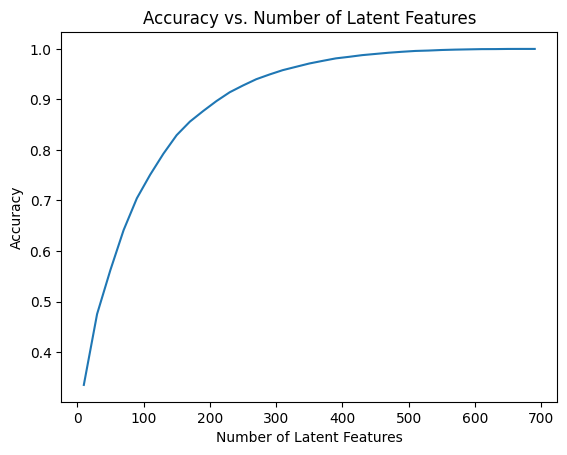

In [51]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [52]:
# Split the dataset into training and testing sets
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrices for training and testing datasets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Identify common users and articles between the training and test datasets
    common_users = user_item_train.index.intersection(user_item_test.index)
    common_articles = user_item_train.columns.intersection(user_item_test.columns)
    
    # Filter the test user-item matrix to include only users and articles that are present in both training and test data
    user_item_test = user_item_test.loc[common_users, common_articles]

    return user_item_train, user_item_test, user_item_test.index, user_item_test.columns


# Create user-item matrices for train and test datasets
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [53]:
# Number of users we can make predictions for in the test set
user_item_train.index.isin(test_idx).sum()

20

In [54]:
# Number of users we aren't able to make predictions for because of the cold start problem
len(df_test['user_id'].unique()) - user_item_train.index.isin(test_idx).sum()


662

In [55]:
# Number of articles we can make predictions for in the test set
user_item_train.columns.isin(test_arts).sum()

574

In [56]:
# Number of articles we aren't able to make predictions for because of the cold start problem
len(test_arts) - user_item_test.shape[1]

0

In [57]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [58]:
# Perform SVD on the training set
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [59]:
u_train.shape

(4487, 4487)

In [60]:
s_train.shape

(714,)

In [61]:
vt_train.shape

(714, 714)

In [62]:
# Find boolean masks for users and articles in both training and test sets
user_index = user_item_train.index.isin(test_idx)
arts_index = user_item_train.columns.isin(test_arts)

In [63]:
# Extract corresponding rows and columns using the boolean masks
u_test = u_train[user_index, :]
vt_test = vt_train[:, arts_index]

In [64]:
vt_test.shape, u_test.shape

((714, 574), (20, 4487))

/Users/RobertHolzmann/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


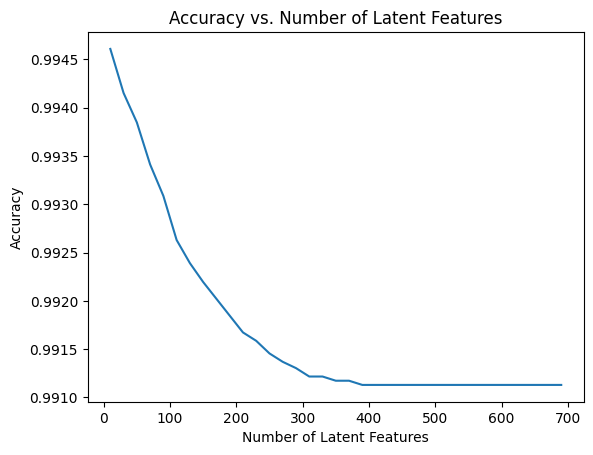

In [65]:
# Iterate through latent features to predict and compare against actual test set

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:  
    # Restructure U, S, and V^T matrices for k latent features
    s_train_new = np.diag(s_train[:k])
    u_train_new = u_train[:, :k]
    vt_train_new = vt_train[:k, :]

    # Update U and V^T matrices for the test set
    u_test_new = u_test[:, :k]
    vt_test_new = vt_test[:k, :]

    # Take dot product
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))

    # Compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_test_pred)

    # Total errors and append to sum_errs
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

accuracy = 1 - np.array(sum_errs)/df.shape[0]
    
plt.plot(num_latent_feats, accuracy);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Evaluation of Latent Features and Recommendation Systems

As the number of latent features increased, **prediction accuracy on the test set declined**, contrary to the **improvement observed in the training data**. This discrepancy is an example of **overfitting** and may also stem from the **small test set size**, which limits the reliability of results. However, despite the decline, accuracy remained high, indicating the decrease may not be significant.

### How to Evaluate Improvement Over the Current System

To determine if the new recommendation systems improve how users find articles, it's essential to compare them to **existing user behavior** and **baseline performance**:

1. **A/B Test Setup**: Compare a **collaborative filtering model** with an **SVD-based model**, using the current recommendation method as a baseline. Measure user interactions with recommended articles.
2. **Baseline Performance**: Track current engagement rates—clicks, article views, and user satisfaction—to have a clear baseline for comparison.
3. **Random Sampling**: Ensure **equal, random distribution** of users to both models and the baseline system for a fair comparison.
4. **Controlled Testing**: Limit tests to a **single variable at a time** to maintain control over external factors.
5. **Test Duration**: Run the experiment for a sufficient period to gather meaningful and statistically significant data.

### Additional Insights

- **User Feedback**: Surveys or polls can provide qualitative insights into user preferences and the effectiveness of recommendations.
- **Cross-Validation**: This technique can help mitigate potential **overfitting** and identify the **optimal number of latent features** for better generalization across different data subsets.

By comparing new systems to the baseline and incorporating these strategies, you can evaluate whether your recommendation systems improve user engagement and satisfaction.

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb',  '--to', 'html'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 896512 bytes to Recommendations_with_IBM.html


0